In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')

In [60]:
titanic_train.describe

<bound method NDFrame.describe of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                 

In [61]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [62]:
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Step 1: Selection of Features
we excluded non-numerical columns from the selected features before applyin sclaing

In [63]:
numeric_columns = ['Age', 'Fare', 'SibSp', 'Parch']

##### plot before scaling

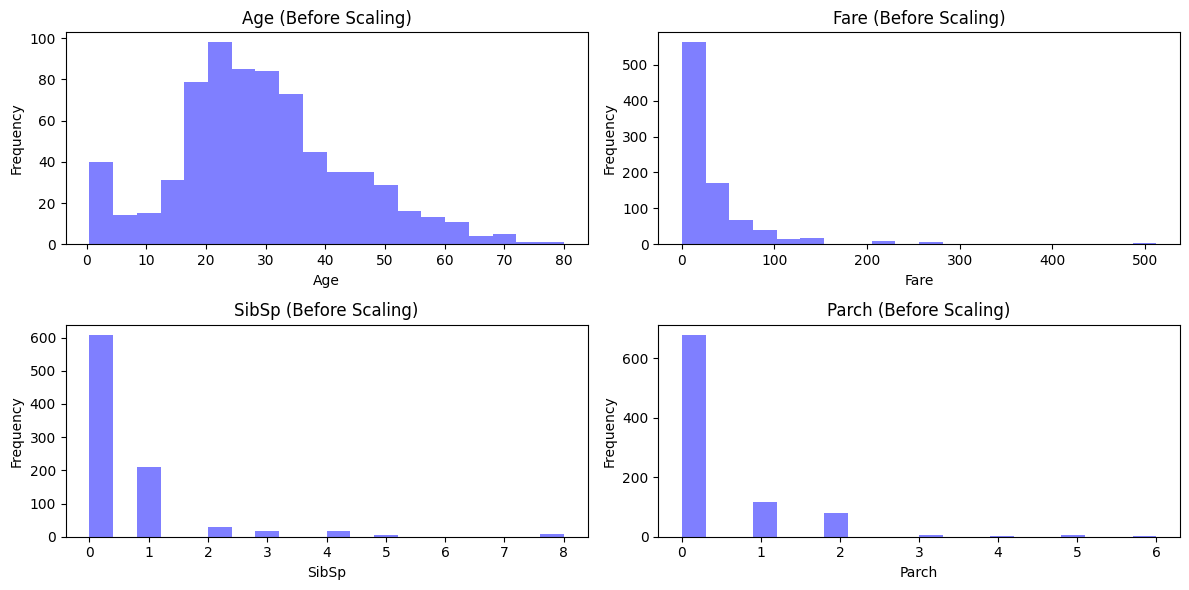

In [64]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(titanic_train[feature].dropna(), bins=20, color='blue', alpha=0.5)
    plt.title(f'{feature} (Before Scaling)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

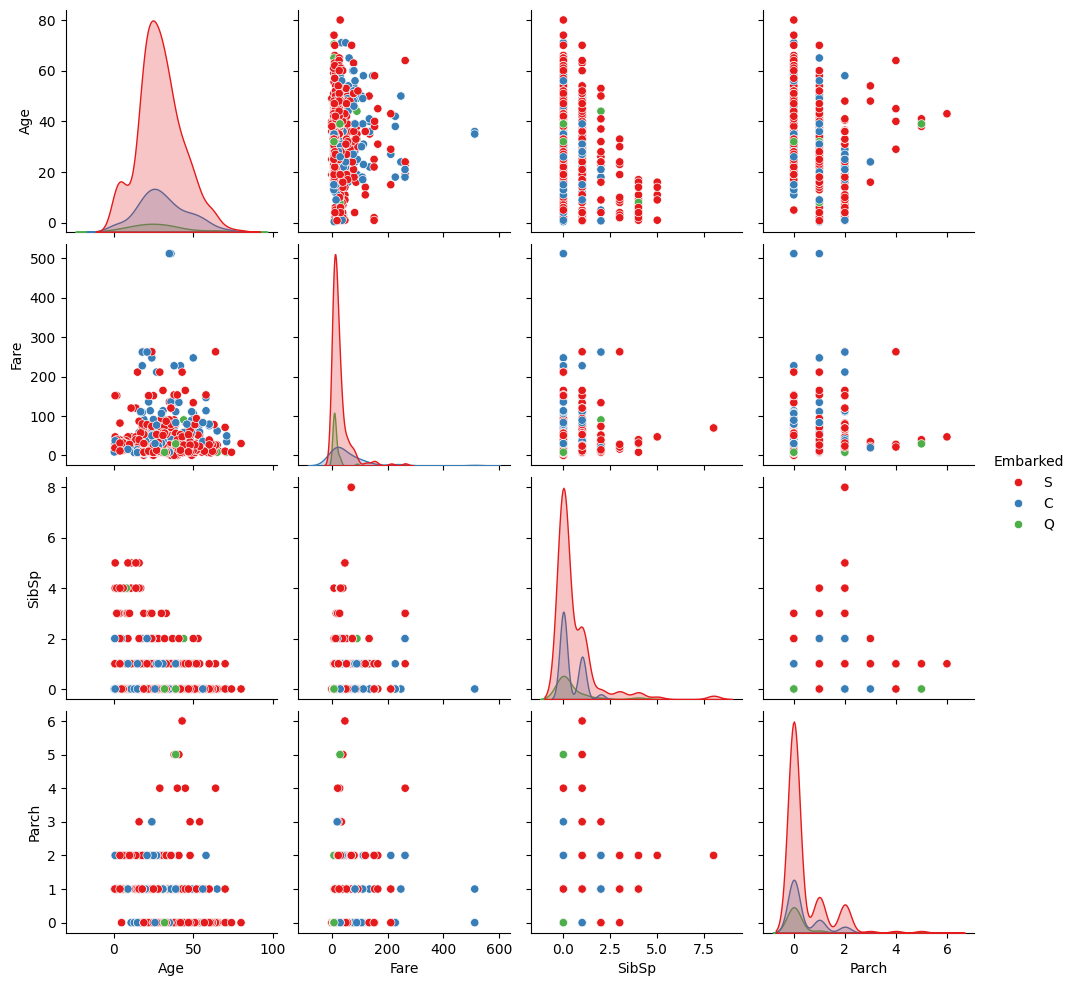

In [65]:
selected_features_with_embarked = pd.concat([titanic_train[numeric_columns], titanic_train['Embarked']], axis=1)

sns.pairplot(selected_features_with_embarked, hue='Embarked', palette='Set1')
plt.show()

### Step 2: Scaling

#### Normalization

In [66]:
titanic_train_copy_norm = copy.deepcopy(titanic_train)
titanic_test_copy_norm = copy.deepcopy(titanic_test)

norm_scaler = MinMaxScaler()
titanic_train_copy_norm[numeric_columns] = norm_scaler.fit_transform(titanic_train_copy_norm[numeric_columns])

titanic_train_copy_norm

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,0.271174,0.125,0.000000,A/5 21171,0.014151,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.472229,0.125,0.000000,PC 17599,0.139136,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,0.321438,0.000,0.000000,STON/O2. 3101282,0.015469,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.434531,0.125,0.000000,113803,0.103644,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,0.434531,0.000,0.000000,373450,0.015713,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,0.334004,0.000,0.000000,211536,0.025374,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,0.233476,0.000,0.000000,112053,0.058556,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,0.125,0.333333,W./C. 6607,0.045771,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,0.321438,0.000,0.000000,111369,0.058556,C148,C


In [67]:
#selected_features_with_embarked_norm = pd.concat([titanic_train_copy_norm[numeric_columns], titanic_train_copy_norm['Embarked']], axis=1)

#sns.pairplot(selected_features_with_embarked_norm, hue='Embarked', palette='Set1')
#plt.show()

In [68]:
#embarked_categories = titanic_train['Embarked'].unique()
#colors = ['blue', 'green', 'red']
#plt.figure(figsize=(10, 6))

#for i, (embarked_category, color) in enumerate(zip(embarked_categories, colors), 1):
 #   subset_data = titanic_train[titanic_train['Embarked'] == embarked_category]
  #  plt.scatter(subset_data['Age'], subset_data['Fare'], label=f'Embarked {embarked_category}', color=color)
#
#plt.title('Age & Fare by Embarked')
#plt.xlabel('Age')
#plt.ylabel('Fare')
#plt.legend()
#plt.grid(True)
#plt.show()

####  Standardization

In [69]:
titanic_train_copy_std = copy.deepcopy(titanic_train)
titanic_test_copy_std = copy.deepcopy(titanic_test)


scaler_std = StandardScaler()
titanic_train_copy_std[numeric_columns] = scaler_std.fit_transform(titanic_train_copy_std[numeric_columns])

titanic_train_copy_std

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.530377,0.432793,-0.473674,A/5 21171,-0.502445,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.571831,0.432793,-0.473674,PC 17599,0.786845,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.254825,-0.474545,-0.473674,STON/O2. 3101282,-0.488854,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.365167,0.432793,-0.473674,113803,0.420730,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,0.365167,-0.474545,-0.473674,373450,-0.486337,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,-0.185937,-0.474545,-0.473674,211536,-0.386671,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.737041,-0.474545,-0.473674,112053,-0.044381,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,0.432793,2.008933,W./C. 6607,-0.176263,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.254825,-0.474545,-0.473674,111369,-0.044381,C148,C
